# Language Translation

* Objective:

Detect Foreign Languages in dataset and perform machine translation backed by Hugging Face models. The quality of machine translation via cloud services has come a very long way and produces high quality results. This notebook shows how the models from Hugging Face give developers a reasonable alternative for local machine translation.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd '/content/drive/MyDrive'

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
import re
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

tqdm.pandas()

In [3]:
dataset = pd.read_excel('./data/merged_clean_data_with_chineese.xlsx')

dataset.isna().sum()

short_description             0
description                   0
caller                        0
group                         0
char_length                   0
word_length                   0
short_char_length             0
short_word_length             0
group_code                    0
char_length_bins              0
cleaned_description          57
cleaned_short_description    50
cleaned_char_length           0
cleaned_word_length           0
cleaned_short_char_length     0
cleaned_short_word_length     0
merged_description            0
dtype: int64

In [4]:
dataset.sample(7)

,short_description,description,caller,group,char_length,word_length,short_char_length,short_word_length,group_code,char_length_bins,cleaned_description,cleaned_short_description,cleaned_char_length,cleaned_word_length,cleaned_short_char_length,cleaned_short_word_length,merged_description
3894,computer running slow,computer running slow,uaevikhj uazfcwgm,GRP_31,22,3,22,3,25,1,computer run slow,computer run slow,17,3,17,3,computer run slow
3987,employee owned mobility agreement,\n\nreceived from: clzwduvj.keflinbj@gmail.com...,clzwduvj keflinbj,GRP_0,294,45,33,4,0,30,support team release device per attach form ow...,own mobility agreement,144,22,22,3,mobility agreement support team release device...
7817,wegen ein sicherheitsupdate kb4272050 sind kei...,wegen ein sicherheitsupdate kb4272050 sind kei...,szfaidhy sivyugjd,GRP_33,120,13,76,8,27,14,wegen ein sicherheitsupdate kb sind keine netz...,wegen ein sicherheitsupdate kb sind keine netz...,108,12,69,8,wegen ein sicherheitsupdate kb sind keine netz...
8463,SID_1 log in issue,\n\nreceived from: rjanhbde.owfkyjcp@gmail.com...,rjanhbde owfkyjcp,GRP_0,138,13,18,4,0,16,could log sid uacyltoe hxgaycze system warm,sid log issue,44,7,14,3,issue could log sid uacyltoe hxgaycze system ...
5880,"vfx3, 4 interco inwarehouse_tools cannot be pr...",error: no number range number has been recorde...,ipwjorsc uboapexr,GRP_13,159,21,53,7,5,18,error number range number record billing docum...,vfx interco inwarehouse tool process,79,12,37,5,vfx interco process error number range number ...
3666,unable to load erp,unable to load erp,olckhmvx pcqobjnd,GRP_0,18,4,18,4,0,1,unable load erp,unable load erp,15,3,15,3,unable load erp
4786,erp SID_34 account locked,erp SID_34 account locked,myaornqv fkjmpxbh,GRP_0,25,4,25,4,0,2,erp sid account lock,erp sid account lock,21,4,21,4,erp sid account lock


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Detect Languages in Merged Descriptions using <a href="https://fasttext.cc/docs/en/language-identification.html">fastText language identification model</a>
</ul></h3>

In [5]:
# download pre-trained language detection model

! wget -O lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

--2021-09-24 11:43:52--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘lid.176.bin’

lid.176.bin         100%[===================>] 125.18M  11.5MB/s    in 12s     

2021-09-24 11:44:05 (10.3 MB/s) - ‘lid.176.bin’ saved [131266198/131266198]



In [6]:
! pip -q install fasttext
import fasttext

# monkey-patch to suppress 'load_model warning from fasttext'
fasttext.FastText.eprint = lambda x: None

     |████████████████████████████████| 68 kB 3.4 MB/s 


In [7]:
# fastText pre-trained language identification model
# (less latency & more accurate)


# lid (Language identification modeel which can recognize 176 languages)
path_to_pretrained_model = './lid.176.bin'
lang_model = fasttext.load_model(path_to_pretrained_model)
test = ["+86 Hi there", "c'est", "bitte", "+81"]
pred = lang_model.predict(test)
pprint(test)
pprint([i[0] for i in pred[0]], compact=True)
pprint([i[0] for i in pred[1]], compact=True)

['+86 Hi there', "c'est", 'bitte', '+81']
['__label__en', '__label__fr', '__label__de', '__label__zh']
[0.72783333, 1.0000362, 0.9995301, 0.18863995]


In [8]:
descriptions = dataset.merged_description.tolist()
len(descriptions)

8499

In [9]:
pred_descriptions = lang_model.predict(descriptions)
lang_descriptions = [re.sub("__label__", "", i[0]) for i in pred_descriptions[0]]
lang_descriptions_conf = [i[0] for i in pred_descriptions[1]]

In [10]:
# detected languages with various confidences
pprint({i[0] for i in pred_descriptions[0]}, compact=True)

{'__label__bs', '__label__ca', '__label__cs', '__label__da', '__label__de',
 '__label__en', '__label__eo', '__label__es', '__label__eu', '__label__fa',
 '__label__fi', '__label__fr', '__label__hi', '__label__hr', '__label__hu',
 '__label__id', '__label__it', '__label__ja', '__label__jv', '__label__kn',
 '__label__mk', '__label__ml', '__label__nl', '__label__no', '__label__pl',
 '__label__pt', '__label__ro', '__label__ru', '__label__sh', '__label__sl',
 '__label__sv', '__label__th', '__label__tl', '__label__tr', '__label__ur',
 '__label__zh'}


In [11]:
dataset['language'] = lang_descriptions
dataset['language_confidence'] = lang_descriptions_conf

# language predictions and associated confidence of prediction
dataset.sample(7)[['merged_description', 'language', 'language_confidence']]

,merged_description,language,language_confidence
204,query external browser,mk,0.249491
7300,follow virus find laptop rectify,en,0.489358
6061,login sid due follow error logon balance erro...,en,0.466214
486,job sid filesys fail job scheduler,en,0.629173
2537,reset follow password erp sid u us plant knem...,en,0.310490
3436,help outlook get update automatically periodic...,en,0.822702
3230,job job fail job scheduler,en,0.893109


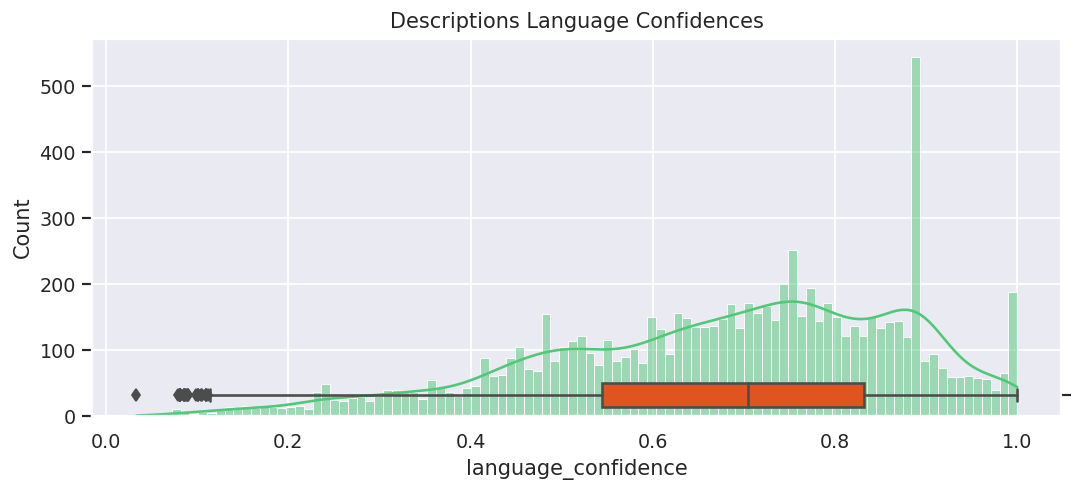

In [12]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.histplot(x=dataset.language_confidence, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(x=dataset.language_confidence, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Descriptions Language Confidences')
plt.show()

In [13]:
# check some predictions with less confidence
dataset[(dataset.language != 'en') & (dataset.language_confidence < 0.6)][['merged_description', 'language', 'language_confidence']]

,merged_description,language,language_confidence
2,ca nt log vpn,da,0.132258
4,skype error,ja,0.081046
12,unable login hr tool sgxqsuojr xwbesorf card,zh,0.104415
14,unable open payslip,fr,0.264625
20,unable check payslip,fr,0.172341
...,...,...,...
8396,security error reisekosten abrechnung programdnty,de,0.254021
8413,langsamer rechner uberprufung niptbwdq,de,0.437996
8416,bluetooth keybankrd defekt dardabthyr,sv,0.245299
8426,new able login system user vvrtgwildj name joh...,de,0.548117


In [14]:
# check some predictions with less confidence
dataset[(dataset.language != 'en') & (dataset.language_confidence > 0.6)][['merged_description', 'language', 'language_confidence']]

,merged_description,language,language_confidence
223,probleme bluescreen hallo es ist erneut passie...,de,0.997537
251,reset password bitte passwort fr mail zurckset...,de,0.870327
255,probleme mit laufwerk laeusvjo,de,0.992616
265,hallo netweaver funktioniert nicht mehr bzw ka...,de,0.999658
270,neues passwort fur accountname tgryhu hgygrtui...,de,0.992012
...,...,...,...
8424,kann setzten ich wei mein erp passwort nicht m...,de,0.998999
8438,fur die up lapel druckt nicht richtig der druc...,de,0.999573
8466,send friday nwfodmhc exurcwkm subject wg die...,de,0.969530
8470,"电脑开机开不出来 to 小贺,早上电脑开机开不出来",zh,0.924405


* We can clearly see that low confidence predictions are not right actually foreign-language but interpreted as such because of out of dictionary words and caller names present in the text. So, we overwrite predictions with confidence less than 0.6 back to english

In [15]:
dataset.loc[(dataset.language != 'en') & (dataset.language_confidence < 0.6), 'language'] = 'en'

In [16]:
dataset[(dataset.language != 'en') & (dataset.language_confidence < 0.6)]  # overwritten

,short_description,description,caller,group,char_length,word_length,short_char_length,short_word_length,group_code,char_length_bins,cleaned_description,cleaned_short_description,cleaned_char_length,cleaned_word_length,cleaned_short_char_length,cleaned_short_word_length,merged_description,language,language_confidence


In [17]:
dataset.language.value_counts()

en    7961
de     485
zh      32
pt       8
fr       3
tl       2
es       2
ca       2
fi       2
it       1
pl       1
Name: language, dtype: int64

In [18]:
dataset.to_excel('./data/merged_clean_data_with_lang_pred.xlsx', index=None)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Translation using txtai pipelines which use <a href="https://huggingface.co/models?search=Helsinki-NLP%2Fopus-mt">hugging-face language translation models</a> as backend</span></strong>
</ul></h3>

In [19]:
# Install `txtai` and all dependencies. Since this notebook is using optional pipelines
# we need to install the pipeline extras package.

!pip -q install git+https://github.com/neuml/txtai#egg=txtai[pipeline]

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 8.4 MB 8.5 MB/s 
     |████████████████████████████████| 2.8 MB 37.1 MB/s 
     |████████████████████████████████| 12.3 MB 190 kB/s 
     |████████████████████████████████| 1.5 MB 46.1 MB/s 
     |████████████████████████████████| 1.2 MB 46.5 MB/s 
     |████████████████████████████████| 4.8 MB 40.5 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 895 kB 40.4 MB/s 
     |████████████████████████████████| 636 kB 39.7 MB/s 
     |████████████████████████████████| 3.3 MB 32.9 MB/s 


In [20]:
# The pipeline has logic to detect the input language,
# load the relevant model that handles translating from source to # target language and return results.
# The translation pipeline also has built-in logic to handle splitting large text
# blocks into smaller sections the models can handle.


from txtai.pipeline import Translation

# Create translation model
translate = Translation()

In [21]:
# The translation quality overall is very high
# Machine translation has made giant leaps and strides the last couple of years
# These models are a solid alternative to cloud translation services if translating on local servers is preferred.

translation = translate("Bonjour, Ca va?", "en")

Downloading:   0%|          | 0.00/938k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/301M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/778k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

In [22]:
translation

'Hello, are you okay?'

In [23]:
def translate_foreign_langauges(row):
    original_descr = row.merged_description
    translated_descr = original_descr
    if row.language != 'en':
        if len(original_descr) > 512:
            # pre-trained models only support sequences of length < 512
            orinal_descr = original_descr[:512]
        translation = translate(original_descr, "en")
        if len(translation) > 0:
            translated_descr = translation

    row['translated_description'] = str(translated_descr.strip())
    return row

In [24]:
translated_dataset = dataset.progress_apply(translate_foreign_langauges, axis=1)

  2%|▏         | 181/8499 [00:00<00:09, 910.17it/s]

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/298M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/797k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/768k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

 12%|█▏        | 1061/8499 [02:11<54:58,  2.25it/s]

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/312M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

 14%|█▍        | 1180/8499 [03:12<2:01:29,  1.00it/s]

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/344M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/814k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/790k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

 19%|█▉        | 1610/8499 [04:22<15:47,  7.27it/s]

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/292M [00:00<?, ?B/s]

 19%|█▉        | 1618/8499 [04:38<15:46,  7.27it/s]

Downloading:   0%|          | 0.00/815k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/803k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

 20%|██        | 1713/8499 [05:28<35:15,  3.21it/s]

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/301M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/832k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/790k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

 37%|███▋      | 3138/8499 [08:29<09:32,  9.36it/s]

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/310M [00:00<?, ?B/s]

 37%|███▋      | 3162/8499 [08:40<09:30,  9.36it/s]

Downloading:   0%|          | 0.00/707k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/791k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

 40%|███▉      | 3378/8499 [09:10<05:17, 16.12it/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/312M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/826k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

 48%|████▊     | 4041/8499 [11:11<13:00,  5.71it/s]

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/309M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/835k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/785k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

 73%|███████▎  | 6181/8499 [18:09<02:26, 15.83it/s]

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/296M [00:00<?, ?B/s]

 73%|███████▎  | 6198/8499 [18:20<02:25, 15.83it/s]

Downloading:   0%|          | 0.00/834k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/826k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

 82%|████████▏ | 6953/8499 [21:08<00:54, 28.52it/s]

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/300M [00:00<?, ?B/s]

 82%|████████▏ | 7003/8499 [21:18<00:52, 28.52it/s]

Downloading:   0%|          | 0.00/820k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

 89%|████████▉ | 7575/8499 [23:05<04:17,  3.59it/s]

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/303M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/782k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

100%|██████████| 8499/8499 [26:23<00:00,  5.37it/s]


In [27]:
# sample translations
translated_dataset[translated_dataset.language == 'de'].sample(20)[['merged_description', 'translated_description']]

,merged_description,translated_description
3817,wk erp drucker druckt nicht sauber seiten wedg...,wk erp printer prints not clean pages wedgrtyh...
1630,druker drucker defekt diese mitteilung ist ein...,Druker printer defective this notification is ...
1829,ich kann meinen vpn nicht offnen,I can't open my vpn
365,labeldrucker wk druckt nicht mehr,labelprinter wk no longer prints
4453,probleme mit chargenverwaltung tmqfjard,problems with batch management tmqfjard
6363,mp fb konto gesperrt keine anmeldung moglich,mp fb account locked no registration possible
2696,anmelden bei outlook seit passwort andern nich...,login to outlook since password others not pos...
3662,drucker wk defekt,printer wk defective
995,bei herrn benutzerkennung potsffwzlo geht rech...,for herrs use detection potsffwzlo goes calcul...
4915,netzwerkkabel des erp drucker verlangern buro...,network cable of the erp printer requires buro...


In [28]:
# sample translations
translated_dataset[translated_dataset.language == 'zh'].sample(20)[['merged_description', 'translated_description']]

,merged_description,translated_description
2003,"电脑登录密码忘记,重置密码。 电脑登录密码忘记,重置密码。","Computer login passwords forget, reset passwor..."
1178,电话机没有声音 电话机没有声音,There's no sound on the phone. There's no soun...
3136,"邮箱无法启动 邮箱无法启动,提示无法创新新的堆栈防护页面。",Mailbox could not be started. Mailbox could no...
7968,"客户提供的在线系统打不开 客户提供的在线送货单生成系统打不开,需尽快解决",The online system offered by the client cannot...
7308,"餐厅电视无法播放视频文件 餐厅电视机无法播放视频文件,请小贺协助完成。谢谢!",Restaurant TV can't play video files. Restaura...
3119,"电脑硬盘故障,请求维修。 电脑硬盘故障,请求维修。","Computer hard drive malfunction, request maint..."
5148,"开不了机 开不了机,显示系统坏了。","I can't turn it on, I can't turn it on, I can'..."
1953,笔记本重新装下系统 把我的笔记本重新装下系统,"The notebooks reset the system, and my noteboo..."
5912,"邮箱登录不了 昨天提示更改密码,改好后可以登录,今天登录不了。",The mailbox can't log in. The password was cha...
4502,用友定期备份不成功 服务器端用友系统最近半个月日备份失败,The server end-of-life back-up failed for the ...


In [29]:
translated_dataset.to_excel('./data/clean_data_tranlsated.xlsx')